# RNN LSTM Project 6 stocks sentiment analysis of market participants

### Objective:

#### Train an LSTM model to accurately predict sentiment of market participants through the proxy of "stock Twits" (https://stocktwits.com)


### Once the model is trained save the most accurate epoch of that model and use model.eval() to efficienty perform inference on a live stream of twits.

### This inference will be applied and backtested over time in order to generate an alpha factor and or risk factor model to be continued next.

### This LSTM inference will be incorporated into a multi alpha factor model next using a Neural network to combine the multiple factors together.


### Trained on an 80/ 20 Split of 1.58M market participant messages

### Load Packages




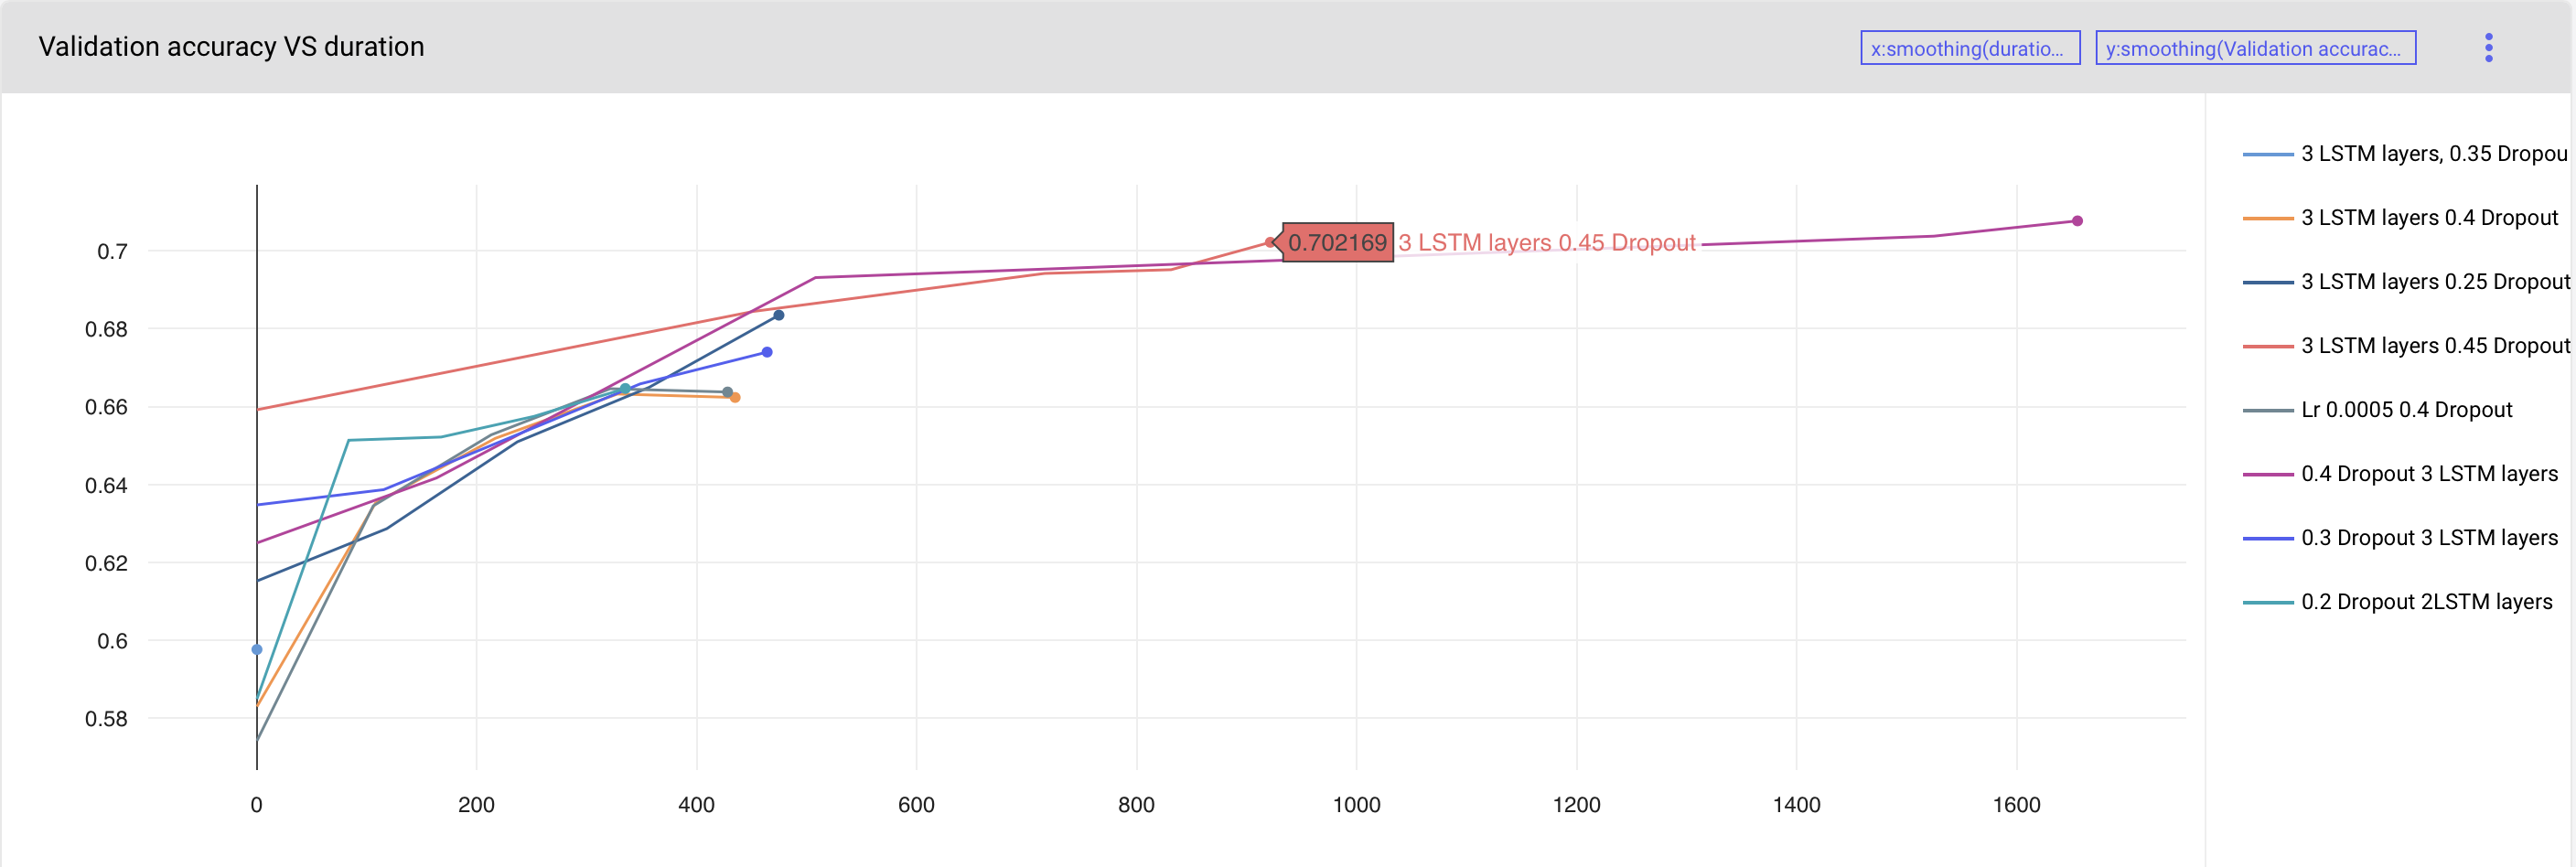

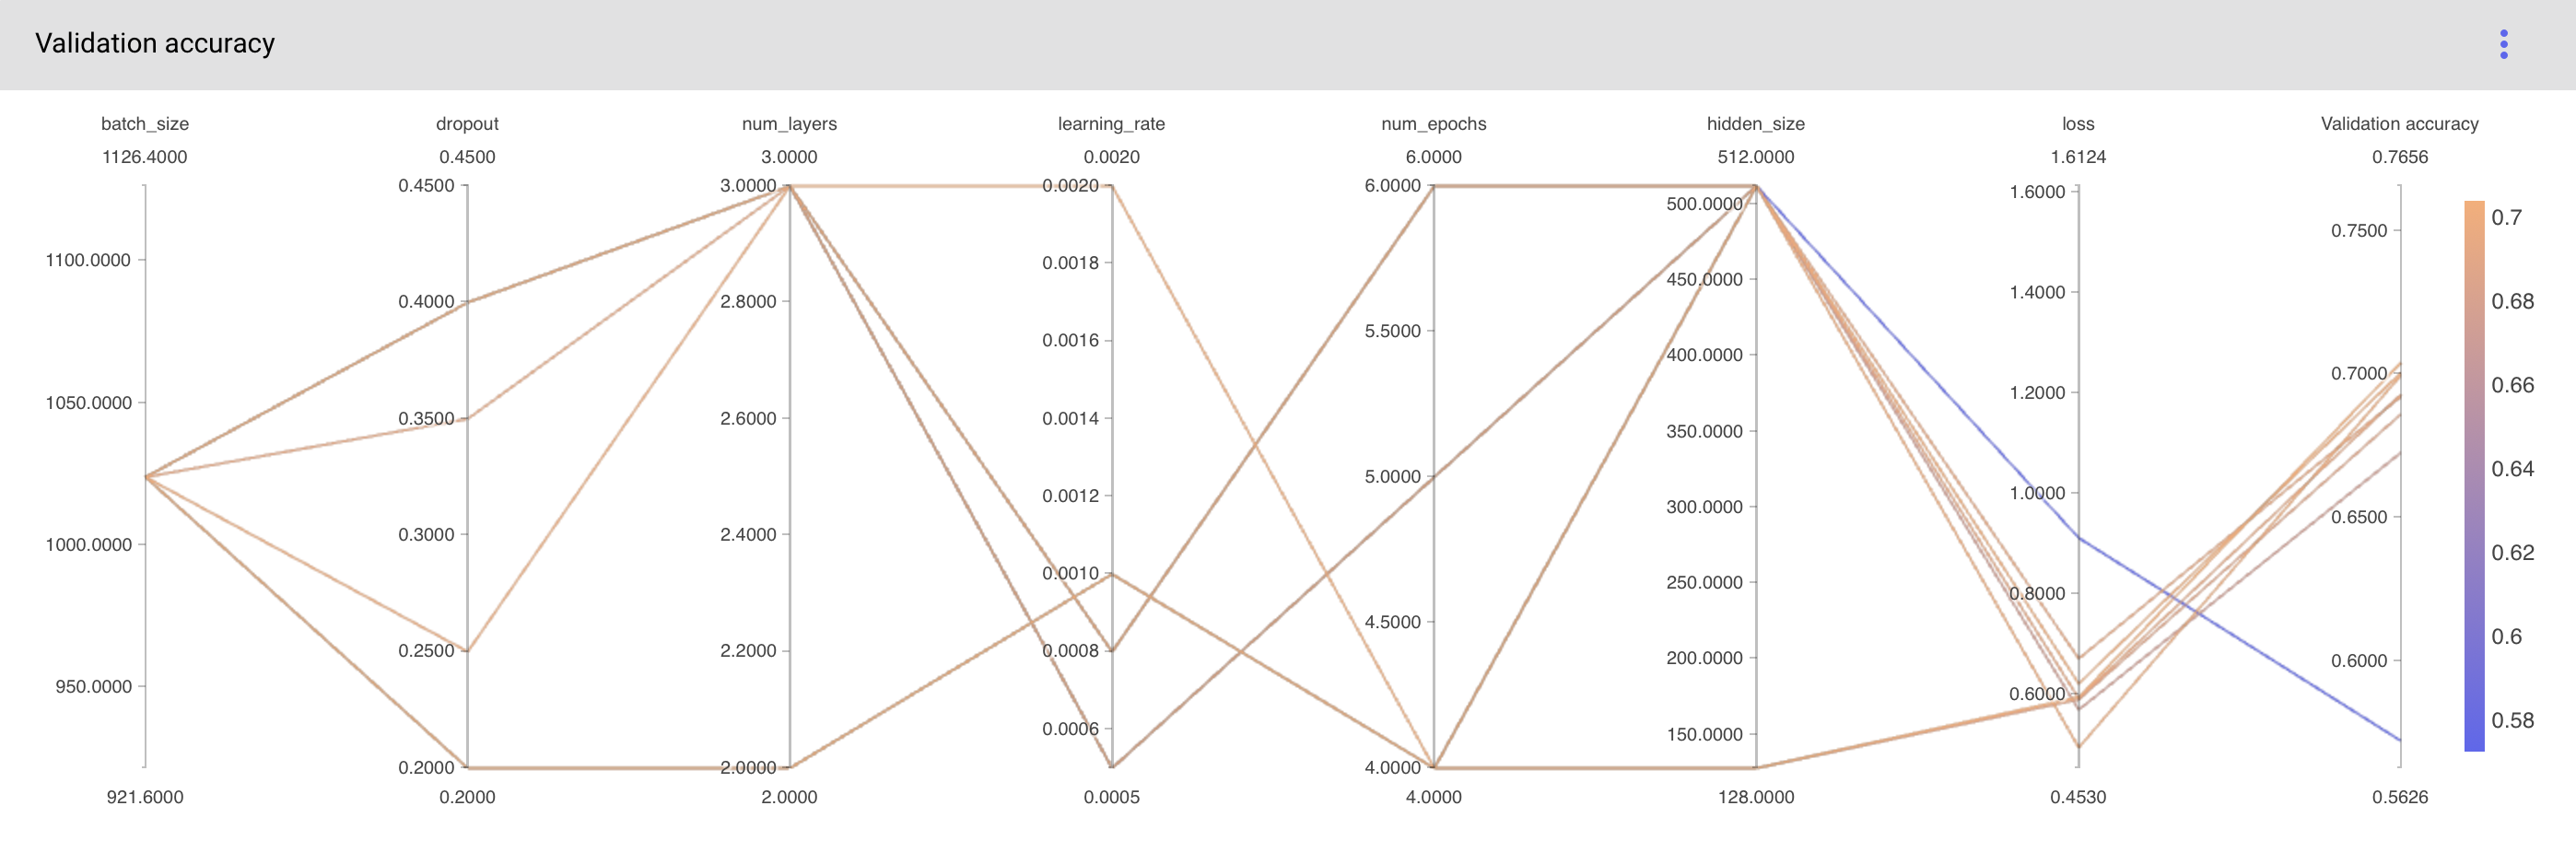

## I will be using an LSTM inorder that the model inherently retains predicitive information from previous sequences of tokenised words

## The LSTM will combine Short and long term memory two seperate a one layer networks "the forget gate" to establish what to remove from LTM and the "Remember gate" to establish what to keep in short term memory

## This will allow the network to retain context from many sequences ago.

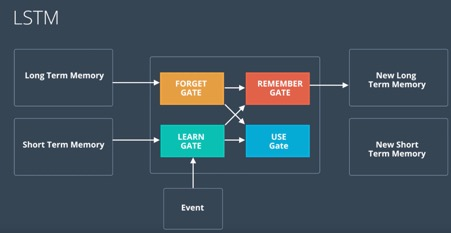

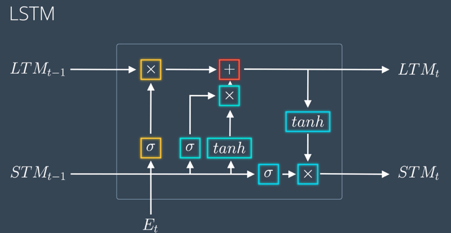

In [1]:
# Optional metrics COMET

#Optional extra metrics
import comet_ml
from comet_ml import Experiment

import json
import nltk
import os
import random
import re
from time import time
import numpy as np

import torch

from torch import nn, optim
import torch.nn.functional as F




    100% |████████████████████████████████| 133kB 4.6MB/s ta 0:00:01
    100% |████████████████████████████████| 389kB 25.4MB/s ta 0:00:01
    100% |████████████████████████████████| 204kB 19.4MB/s ta 0:00:01
    100% |████████████████████████████████| 153kB 22.7MB/s ta 0:00:01
  Running setup.py bdist_wheel for nvidia-ml-py3 ... done
  Stored in directory: /root/.cache/pip/wheels/e4/1d/06/640c93f5270d67d0247f30be91f232700d19023f9e66d735c7
  Running setup.py bdist_wheel for configobj ... done
  Stored in directory: /root/.cache/pip/wheels/f1/e4/16/4981ca97c2d65106b49861e0b35e2660695be7219a2d351ee0
Successfully built nvidia-ml-py3 configobj
requests 2.18.4 has requirement urllib3<1.23,>=1.21.1, but you'll have urllib3 1.25.3 which is incompatible.
botocore 1.12.7 has requirement urllib3<1.24,>=1.20, but you'll have urllib3 1.25.3 which is incompatible.
  Found existing installation: urllib3 1.22
    Uninstalling urllib3-1.22:
      Successfully uninstalled urllib3-1.22


/opt/conda/lib/python3.6/site-packages/requests/__init__.py:80: RequestsDependencyWarning: urllib3 (1.25.3) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)


## Introduction
When deciding the value of a company, it's important to follow the news. For example, a product recall or natural disaster in a company's product chain. You want to be able to turn this information into a signal. Currently, the best tool for the job is a Neural Network. 

For this project, you'll use posts from the social media site [StockTwits](https://en.wikipedia.org/wiki/StockTwits). The community on StockTwits is full of investors, traders, and entrepreneurs. Each message posted is called a Twit. This is similar to Twitter's version of a post, called a Tweet. You'll build a model around these twits that generate a sentiment score.

We've collected a bunch of twits, then hand labeled the sentiment of each. To capture the degree of sentiment, we'll use a five-point scale: very negative, negative, neutral, positive, very positive. Each twit is labeled -2 to 2 in steps of 1, from very negative to very positive respectively. You'll build a sentiment analysis model that will learn to assign sentiment to twits on its own, using this labeled data.

The first thing we should to do, is load the data.

## Import Twits 
### Load Twits Data 
This JSON file contains a list of objects for each twit in the `'data'` field:

```
{'data':
  {'message_body': 'Neutral twit body text here',
   'sentiment': 0},
  {'message_body': 'Happy twit body text here',
   'sentiment': 1},
   ...
}
```

The fields represent the following:

* `'message_body'`: The text of the twit.
* `'sentiment'`: Sentiment score for the twit, ranges from -2 to 2 in steps of 1, with 0 being neutral.


To see what the data look like by printing the first 10 twits from the list. 

In [2]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'twits.json'), 'r') as f:
    twits = json.load(f)

print(twits['data'][:10])


[{'message_body': '$FITB great buy at 26.00...ill wait', 'sentiment': 2, 'timestamp': '2018-07-01T00:00:09Z'}, {'message_body': '@StockTwits $MSFT', 'sentiment': 1, 'timestamp': '2018-07-01T00:00:42Z'}, {'message_body': '#STAAnalystAlert for $TDG : Jefferies Maintains with a rating of Hold setting target price at USD 350.00. Our own verdict is Buy  http://www.stocktargetadvisor.com/toprating', 'sentiment': 2, 'timestamp': '2018-07-01T00:01:24Z'}, {'message_body': '$AMD I heard there’s a guy who knows someone who thinks somebody knows something - on StockTwits.', 'sentiment': 1, 'timestamp': '2018-07-01T00:01:47Z'}, {'message_body': '$AMD reveal yourself!', 'sentiment': 0, 'timestamp': '2018-07-01T00:02:13Z'}, {'message_body': '$AAPL Why the drop? I warren Buffet taking out his position?', 'sentiment': 1, 'timestamp': '2018-07-01T00:03:10Z'}, {'message_body': '$BA bears have 1 reason on 06-29 to pay more attention https://dividendbot.com?s=BA', 'sentiment': -2, 'timestamp': '2018-07-01T

### Length of Data
Now let's look at the number of twits in dataset. Print the number of twits below.

In [3]:
"""print out the number of twits"""

# TODO Implement 
print(len(twits['data']))


1548010


### Split Message Body and Sentiment Score

In [4]:
messages = [twit['message_body'] for twit in twits['data']]
# Since the sentiment scores are discrete, we'll scale the sentiments to 0 to 4 for use in our network
sentiments = [twit['sentiment'] + 2 for twit in twits['data']]



## Preprocessing the Data
With our data in hand we need to preprocess our text. These twits are collected by filtering on ticker symbols where these are denoted with a leader $ symbol in the twit itself. For example,

`{'message_body': 'RT @google Our annual look at the year in Google blogging (and beyond) http://t.co/sptHOAh8 $GOOG',
 'sentiment': 0}`

The ticker symbols don't provide information on the sentiment, and they are in every twit, so we should remove them. This twit also has the `@google` username, again not providing sentiment information, so we should also remove it. We also see a URL `http://t.co/sptHOAh8`. Let's remove these too.

The easiest way to remove specific words or phrases is with regex using the `re` module. You can sub out specific patterns with a space:

```python
re.sub(pattern, ' ', text)
```
This will substitute a space with anywhere the pattern matches in the text. Later when we tokenize the text, we'll split appropriately on those spaces.

### Pre-Processing

In [5]:
nltk.download('wordnet')


def preprocess(message):
    """
    This function takes a string as input, then performs these operations: 
        - lowercase
        - remove URLs
        - remove ticker symbols 
        - removes punctuation
        - tokenize by splitting the string on whitespace 
        - removes any single character tokens
    
    Parameters
    ----------
        message : The text message to be preprocessed.
        
    Returns
    -------
        tokens: The preprocessed text into tokens.
    """ 
    #TODO: Implement 
    
    # Lowercase the twit message
    text = message.lower()
    
    # Replace URLs with a space in the message
    text = re.sub(r'http\S+',' ', text, flags=re.MULTILINE)
    
    # Replace ticker symbols with a space. The ticker symbols are any stock symbol that starts with $.
    text = re.sub(r'\$\S+', ' ', text)
    
    # Replace StockTwits usernames with a space. The usernames are any word that starts with @.
    text = re.sub(r'\@\S+', ' ', text)

    # Replace everything not a letter with a space
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    
    # Tokenize by splitting the string on whitespace into a list of words
    tokens = text.split(' ')

    # Lemmatize words using the WordNetLemmatizer. You can ignore any word that is not longer than one character.
    wnl = nltk.stem.WordNetLemmatizer()
    
    tokens = [wnl.lemmatize(t) for t in tokens if len(t) > 1]
     
    return tokens



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [6]:
# # Converts the list into text using strings
# def convert(list):
    
#     s = [str(i) for i in list]
#     result = " ".join(s)
    
#     return result

# messages_text = convert(messages)
# messages_text[0:100]


### Preprocess All the Twits 
Now we can preprocess each of the twits in our dataset. Apply the function `preprocess` to all the twit messages.

In [7]:
# TODO Implement



tokenized = [preprocess(m) for m in messages]



### Bag of Words
Now with all of our messages tokenized, we want to create a vocabulary and count up how often each word appears in our entire corpus. Use the [`Counter`](https://docs.python.org/3.1/library/collections.html#collections.Counter) function to count up all the tokens.

In [8]:
from collections import Counter

"""
Create a vocabulary by using Bag of words
"""
# TODO: Implement 

all_tweets = lambda t: [twt for tokenized in t for twt in tokenized]
all_tweets = all_tweets(tokenized)

bow = Counter(all_tweets)



In [9]:
# Test out sample tokenized word

bow['arrow']


118

### Frequency of Words Appearing in Message

remove frequent and rare words:

stop words 'It', 'the', 'and' add little to the sense of a piece of text



In [10]:
"""
Set the following variables:
    freqs
    low_cutoff
    high_cutoff
    K_most_common
"""

# TODO Implement 
total_count = len(bow)
# Dictionart that contains the Frequency of words appearing in messages.
# The key is the token and the value is the frequency of that word in the corpus.
freqs = {word: count/total_count for word, count in bow.items()}

# Float that is the frequency cutoff. Drop words with a frequency that is lower or equal to this number.
low_cutoff = 0.00007

# Integer that is the cut off for most common words. Drop words that are the `high_cutoff` most common words.
high_cutoff = 16

# The k most common words in the corpus. Use `high_cutoff` as the k.
K_most_common = bow.most_common(n=high_cutoff)


filtered_words = [word for word in freqs if (freqs[word] > low_cutoff and word not in K_most_common)]
print(K_most_common)
len(filtered_words) 



[('the', 398753), ('to', 379487), ('is', 284865), ('for', 273537), ('on', 241663), ('of', 211334), ('and', 208471), ('in', 205307), ('this', 203540), ('it', 193484), ('at', 138453), ('will', 128180), ('up', 121567), ('are', 101424), ('you', 94275), ('that', 89655)]


22858

### Updating Vocabulary by Removing Filtered Words
Let's creat three variables that will help with our vocabulary.

### A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
                                # Starting the list at 1   >

In [11]:
"""
Set the following variables:
    vocab
    id2vocab
    filtered
"""

#TODO Implement

# A dictionary for the `filtered_words`. The key is the word and value is an id that represents the word. 
                                # Starting the list at 1   >
vocab = {word:ii for ii, word in enumerate(filtered_words, 1)}

# Reverse of the `vocab` dictionary. The key is word id and value is the word. 
id2vocab = {ii:word for word, ii in enumerate(filtered_words, 1)}

# tokenized with the words not in `filtered_words` removed.
filtered = [[word for word in message if word in vocab] for message in tokenized]

In [12]:
print(filtered[0:10])




[['great', 'buy', 'at', 'ill', 'wait'], [], ['staanalystalert', 'for', 'jefferies', 'maintains', 'with', 'rating', 'of', 'hold', 'setting', 'target', 'price', 'at', 'usd', 'our', 'own', 'verdict', 'is', 'buy'], ['heard', 'there', 'guy', 'who', 'know', 'someone', 'who', 'think', 'somebody', 'know', 'something', 'on', 'stocktwits'], ['reveal', 'yourself'], ['why', 'the', 'drop', 'warren', 'buffet', 'taking', 'out', 'his', 'position'], ['bear', 'have', 'reason', 'on', 'to', 'pay', 'more', 'attention'], ['ok', 'good', 'we', 're', 'not', 'dropping', 'in', 'price', 'over', 'the', 'weekend', 'lol'], ['daily', 'chart', 'we', 'need', 'to', 'get', 'back', 'to', 'above'], ['drop', 'per', 'week', 'after', 'spike', 'if', 'no', 'news', 'in', 'month', 'back', 'to', 'if', 'bo', 'then', 'bingo', 'what', 'is', 'the', 'odds']]


### Balancing the classes


since 50% of twits are labeled as neutral this will make the model inherently 50%
accurate if it just predicted neutral constantly.

As such we rebalance to get a more uniformly distributed sample of stock twits.

This will enable the model to train more evenly on different sentiments.

We will also apply a dropout inorder to get the model to not overfit and to make sure all tensor nodes are training and prevent the model relying too heavily on certain nodes.


In [13]:
balanced = {'messages': [], 'sentiments':[]}

n_neutral = sum(1 for each in sentiments if each == 2)
print('the number of neutral setimenets are: {}\n'.format(n_neutral))
# 2 = Neutral sentiment
# here we get the total number of sentiments to test against
N_examples = len(sentiments)
print('the number of total sentiments in our sample is: {}\n'.format(N_examples))

print('Neutral sentiments make up {} percent of the sample population of twits\n'.format(round((n_neutral/N_examples)*100)))

# what probability to use to get down to only circa 20% neutral twits vs 50% initially

keep_prob = (N_examples - n_neutral)/4/n_neutral

# The keep probability for reducing the neutrak sentiments down to circa 20%
print('The probability used to reduce the amount of neutral words is: {} percent\n'.format(round(keep_prob*100)))


for idx, sentiment in enumerate(sentiments):
    message = filtered[idx]
    if len(message) == 0:
        # skip this message because it has length zero
        continue
        
        # If the tweet sentiment is random either automatically reject to add to our messages and setiments
        # or if the random.random value is less than keep prob then we allow the neutral word to proceed and be added.
        
    elif sentiment != 2 or random.random() < keep_prob:
        
        balanced['messages'].append(message)
        balanced['sentiments'].append(sentiment) 
        

the number of neutral setimenets are: 701597

the number of total sentiments in our sample is: 1548010

Neutral sentiments make up 45 percent of the sample population of twits

The probability used to reduce the amount of neutral words is: 30 percent



In [14]:
print(balanced['messages'][0:10])
print(balanced['sentiments'][0:10])

[['great', 'buy', 'at', 'ill', 'wait'], ['staanalystalert', 'for', 'jefferies', 'maintains', 'with', 'rating', 'of', 'hold', 'setting', 'target', 'price', 'at', 'usd', 'our', 'own', 'verdict', 'is', 'buy'], ['heard', 'there', 'guy', 'who', 'know', 'someone', 'who', 'think', 'somebody', 'know', 'something', 'on', 'stocktwits'], ['why', 'the', 'drop', 'warren', 'buffet', 'taking', 'out', 'his', 'position'], ['bear', 'have', 'reason', 'on', 'to', 'pay', 'more', 'attention'], ['ok', 'good', 'we', 're', 'not', 'dropping', 'in', 'price', 'over', 'the', 'weekend', 'lol'], ['daily', 'chart', 'we', 'need', 'to', 'get', 'back', 'to', 'above'], ['drop', 'per', 'week', 'after', 'spike', 'if', 'no', 'news', 'in', 'month', 'back', 'to', 'if', 'bo', 'then', 'bingo', 'what', 'is', 'the', 'odds'], ['strong', 'buy'], ['short', 'ratio', 'is', 'at', 'and', 'short', 'to', 'float', 'is', 'via']]
[4, 4, 3, 3, 0, 3, 4, 0, 4, 0]


In [15]:
n_neutral = sum(1 for each in balanced['sentiments'] if each == 2)
N_examples = len(balanced['sentiments'])
n_neutral/N_examples

0.1950604569886999

## Convert our word tokens into integers that we can feed into the LSTM.

In [16]:
# apply the vocab method to each word in each message within each message block in the balanced words dataset

# i.e. the balanced words dataset has the amount of neutral message blocks reduced to circa 20%

token_ids =[[vocab[word] for word in message] for message in balanced['messages']]

sentiments = balanced['sentiments']

## Neural Network

Now define our Network


#### Embed -> RNN -> Dense -> Softmax
### Implement the text classifier

The RNN network model named "TextClassifer" - consists of three main parts: 1) init function `__init__` 2) forward pass `forward`  3) hidden state `init_hidden`. 

For this network's `forward` pass, we use softmax instead of sigmoid. The reason we are not using sigmoid is that the output of NN is not a binary we are doing multiclass predictions with a probability distributiob. 

In our network, sentiment scores have 5 possible outcomes. We are looking for an outcome with the highest probability thus softmax is a better choice.

### Instead of using one hot encoding, due to the size of the corpus we'll end up with a huge one hot input vector of mostly zero's.

### As such its more efficient to use a hidden layer of our embedding layer 

### From the embedding layer we can use it as a lookup table in unison with the one hot input vector to get the embedding layers particular weights for that word.


#### The important part is that if two words are similar in their contexts (that is, what words are likely to appear around them), then our model needs to output very similar results for these two words. And one way for the network to output similar context predictions for these two words is if the word vectors are similar. 


##### So, if two words have similar contexts, then our network is motivated to learn similar word vectors for these two words!

#### You can use the cosine similarity to identify the distance between words and plot this for the whole sample

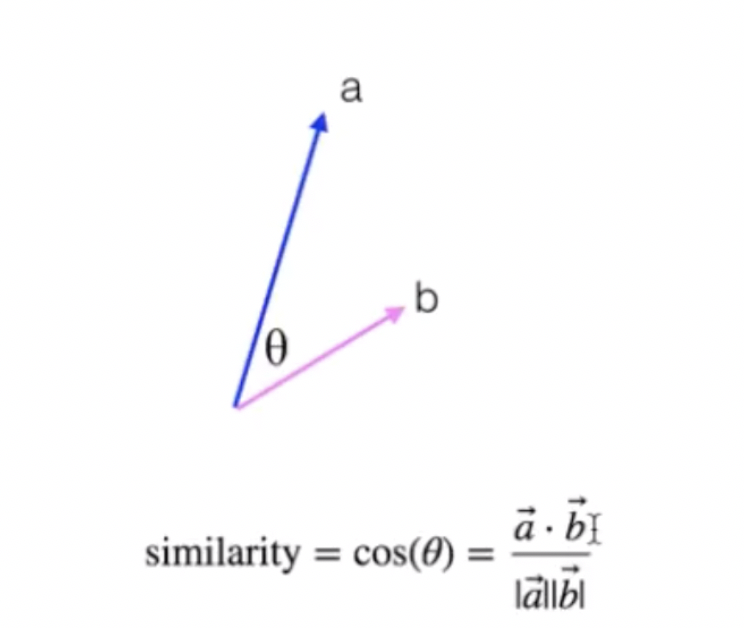

In [1]:
class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_size, lstm_size, output_size, lstm_layers=1, dropout=0.1):
        """
        Initialize the model by setting up the layers.
        
        Parameters
        ----------
            vocab_size : The vocabulary size.
            embed_size : The embedding layer size.
            lstm_size : The LSTM layer size.
            output_size : The output size.
            lstm_layers : The number of LSTM layers.
            dropout : The dropout probability.
        """
        
        super().__init__()
        self.vocab_size = vocab_size
        self.embed_size = embed_size
        self.lstm_size = lstm_size
        self.output_size = output_size
        self.lstm_layers = lstm_layers
        self.dropout = dropout
        
        # TODO Implement

        # Setup embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim=embed_size)
        
        # Setup additional layers
        self.lstm = nn.LSTM(embed_size, lstm_size, lstm_layers,
                              dropout=dropout,batch_first=False)
        
        self.dropout = nn.Dropout(dropout)
        # we want the model to be fully connected so the LSTM layer outputs to every class we're predicting
        self.fc = nn.Linear(lstm_size, output_size)
        
        self.softmax = nn.LogSoftmax(dim=1)

    def init_hidden(self, batch_size):
        """ 
        Initializes hidden state
        
        Parameters
        ----------
            batch_size : The size of batches.
        
        Returns
        -------
            hidden_state
            
        """
        
        # TODO Implement 
        
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        
        # using the generator
        weight = next(self.parameters()).data
        
        # As we go throug mini batches we dont want to mix up gradients so we zero them out
        hidden_state = (weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_(),
                       weight.new(self.lstm_layers, batch_size, self.lstm_size).zero_())
        
        
        return hidden_state


    def forward(self, nn_input, hidden_state):
        """
        Perform a forward pass of our model on nn_input.
        
        Parameters
        ----------
            nn_input : The batch of input to the NN.
            hidden_state : The LSTM hidden state.

        Returns
        -------
            logps: log softmax output
            hidden_state: The new hidden state.

        """
        
        # TODO Implement 
        
        nn_input = nn_input.long()
        
        embeds = self.embedding(nn_input)
        
        lstm_out, hidden_state = self.lstm(embeds, hidden_state)
        
        lstm_out = lstm_out[-1,:,:]
        
        # drop a certain percentage of the tensors to improve model training and not over train 
        # certain tensors more than others
        out = self.dropout(lstm_out)
        
        out = self.fc(out)
        
        # use the logsoftmax (created above)mmore efficient to get the probabilities out for each class
        logps = self.softmax(out)           
        
        
        return logps, hidden_state

NameError: name 'nn' is not defined

### View Model

In [18]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextClassifier(len(vocab), 10, 6, 5, dropout=0.1, lstm_layers=2)
model.embedding.weight.data.uniform_(-1, 1)
input = torch.randint(0, 1000, (5, 4), dtype=torch.int64)
hidden = model.init_hidden(4)

logps, _ = model.forward(input, hidden)
print(logps)

tensor([[-1.4646, -1.5817, -1.7470, -1.4167, -1.9215],
        [-1.4673, -1.6021, -1.7564, -1.3891, -1.9240],
        [-1.4453, -1.5940, -1.7918, -1.3855, -1.9355],
        [-1.4634, -1.6071, -1.7193, -1.4239, -1.9096]])


## Training
### DataLoaders and Batching
Now we should build a generator that we can use to loop through our data. It'll be more efficient if we can pass our sequences in as batches. Our input tensors should look like `(sequence_length, batch_size)`. So if our sequences are 40 tokens long and we pass in 25 sequences, then we'd have an input size of `(40, 25)`.

If we set our sequence length to 40, what do we do with messages that are more or less than 40 tokens? For messages with fewer than 40 tokens, we will pad the empty spots with zeros. We should be sure to **left** pad so that the RNN starts from nothing before going through the data. If the message has 20 tokens, then the first 20 spots of our 40 long sequence will be 0. If a message has more than 40 tokens, we'll just keep the first 40 tokens.

In [19]:
def dataloader(messages, labels, sequence_length=30, batch_size=32, shuffle=False):
    """ 
    Build a dataloader.
    """
    if shuffle:
        indices = list(range(len(messages)))
        random.shuffle(indices)
        messages = [messages[idx] for idx in indices]
        labels = [labels[idx] for idx in indices]

    total_sequences = len(messages)

    for ii in range(0, total_sequences, batch_size):
        batch_messages = messages[ii: ii+batch_size]
        
        # First initialize a tensor of all zeros
        batch = torch.zeros((sequence_length, len(batch_messages)), dtype=torch.int64)
        for batch_num, tokens in enumerate(batch_messages):
            token_tensor = torch.tensor(tokens)
            # Left pad!
            # for each batch of messages get the length of sequence - the len of this token tensor
            #in order to generate the start index
            start_idx = max(sequence_length - len(token_tensor), 0)
            batch[start_idx:, batch_num] = token_tensor[:sequence_length]
        
        label_tensor = torch.tensor(labels[ii: ii+len(batch_messages)])
        
        yield batch, label_tensor

### Training and  Validation
With our data in nice shape, we'll split it into training and validation sets.

In [20]:
"""
Split data into training and validation datasets. Use an appropriate split size.
The features are the `token_ids` and the labels are the `sentiments`.
"""   

features_train_test_split = 0.8


# if features_train_test_split != labels_train_test_split:
#     print('features and labels arent same percentage change back to be same')

#     break
    
    
# TODO Implement 
# FEATURES



train_token_percent = int(len(token_ids) * features_train_test_split)


train_features = token_ids[0:train_token_percent]
valid_features = token_ids[train_token_percent:]


# LABELS
train_label_percent = int(len(sentiments) * features_train_test_split)

train_labels = sentiments[0:train_label_percent]
valid_labels = sentiments[train_label_percent:]

print(len(sentiments))
print(len(token_ids))

1031229
1031229


In [21]:

print('train features amount to {}'.format(len(train_features)))
print('validation features amount to {}'.format(len(valid_features)))
print('the total features tokenids are {}\n'.format(len(train_features)+len(valid_features)))





print('train labels amount to {}'.format(len(train_labels)))
print('validation labels amount to {}'.format(len(valid_labels)))

print('the total sentiment labels are {}\n '.format(len(train_labels)+len(valid_labels)))


if (len(train_labels)+len(valid_labels)) ==(len(sentiments)):
    print('The total sentiment labels split between train and validation \namount to the input sentiments labels total')

train features amount to 824983
validation features amount to 206246
the total features tokenids are 1031229

train labels amount to 824983
validation labels amount to 206246
the total sentiment labels are 1031229
 
The total sentiment labels split between train and validation 
amount to the input sentiments labels total


In [22]:
text_batch, labels = next(iter(dataloader(train_features, train_labels, sequence_length=20, batch_size=64)))
model = TextClassifier(len(vocab)+1, 200, 128, 5, dropout=0.)
hidden = model.init_hidden(64)
logps, hidden = model.forward(text_batch, hidden)

### Training
It's time to train the neural network!

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextClassifier(len(vocab)+1, 1024, 512, 5, lstm_layers=3, dropout=0.40)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(22859, 1024)
  (lstm): LSTM(1024, 512, num_layers=3, dropout=0.4)
  (dropout): Dropout(p=0.4)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (softmax): LogSoftmax()
)

In [24]:


"""
Train your model with dropout. Make sure to clip your gradients.
Print the training loss, validation loss, and validation accuracy for every 100 steps.
"""
# Comet ML
experiment = Experiment(api_key="key",
                        project_name="key", workspace="key")







epochs = 6
batch_size = 1024
learning_rate = 0.0008
best_val_accuracy = 0
clip = 5 # Gradient clipping to 
# we use clip grad norm since
# clip: The maximum gradient value to clip at (to prevent exploding gradients)
print_every = 100

hyper_params = {
    "sequence_length": 20,
    "input_size": 512,
    "dropout": 0.40,
    "hidden_size": 512,
    "num_layers": 3,
    "batch_size": 1024,
    "num_epochs": 6,
    "learning_rate": 0.0008
}


experiment.log_parameters(hyper_params)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()



for epoch in range(epochs):
    experiment.log_current_epoch(epoch)
    print('Starting epoch {}'.format(epoch + 1))
    
    steps = 0
    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=20, shuffle=True):
        steps += 1
        #Once at 600 steps break to next batch
        if steps == 600:
            break
        
        hidden = model.init_hidden(batch_size)
        
        # Set Device
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
        
        # TODO Implement: Train Model
        
        
        
        # we backpropegate through the entire training history
        hidden = tuple([each.data for each in hidden])
        
        #Zero out the gradients as we back propegate through the network
        model.zero_grad()
        
        #get tuple out of the model for backward pass for log probs and the hidden layer
        logps, hidden = model(text_batch, hidden)
        
        loss = criterion(logps, labels)
        #Backward pass loss
        loss.backward()
        
        # we use clip grad norm since
        # clip: The maximum gradient value to clip at (to prevent exploding gradients)
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Take one step using the updated values from the optimizer
        optimizer.step()
        
        
        
        if steps % print_every == 0:
            start = time()
            model.eval()
            
            # TODO Implement: Print metrics
            
            # perform validation using init hidden function
            valid_hidden = model.init_hidden(batch_size)
            
            valid_losses = []
            accuracy = []
            
            for text_batch, labels in dataloader(valid_features, valid_labels, batch_size=batch_size, 
                                                 sequence_length=20, shuffle = True):
                
                if text_batch.size(1) != batch_size:
                    break
                for each in hidden:
                    # perform validation on the devide cpu / GPU also for performance / continuity
                    each.to(device)
                    # perform the backpropegation
                    valid_hidden = tuple([each.data for each in valid_hidden]) 
                    
                    text_batch, labels = text_batch.to(device), labels.to(device)
                    
                    #use the model to derive the validation loop probabilities and its hidden layer
                    valid_logps, valid_hidden = model(text_batch, valid_hidden)
                    
                    valid_loss = criterion(valid_logps.squeeze(), labels.long())
                    
                    #add this batch add the loss to the running measure of validation loss
                    valid_losses.append(valid_loss.item()) 
            
                    #Accuracy
                    # to move from soft max output probs to actual probabilities 
                    # we take the exponent of validation loss
                    ps = torch.exp(valid_logps)
                    
                    # get tuple out from ps tensor output along the columns, retrieve the 1st highest one
                    top_p, top_class = ps.topk(1, dim=1)
                    
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())
                    
                    # Log to Comet.ml
                    #rounded_accuracy = np.mean(accuracy)
                    #rounded_accuracy = round(accuracy, 5)
                    #comet ai log accuracy
                    #experiment.log_metric("accuracy", rounded_accuracy, step=steps)
                    outPut_accuracy = round(np.mean(accuracy), 6)
                    experiment.log_metric("Validation accuracy", outPut_accuracy, step=steps)
            
            end_time_ = time()
            model.train()
            
            current_val_accuracy = sum(accuracy)/len(accuracy)
            
            # print out running values
            print('Epoch {}/{}...'.format(epoch+1, epochs)
                    ,'Step: {}...'.format(steps)
                  ,'Train Loss: {:.6f}...'.format(loss.item()),
                 'Valid Loss: {:.6f}'.format(np.mean(valid_losses)),
                 'Accuracy: {:.6f}'.format(np.mean(accuracy)),
                 'Time: {:.3f}'.format(end_time_-start))
            
            if current_val_accuracy > best_val_accuracy:
                
                torch.save(model,'p6_epoch2.pth')
                best_val_accuracy=current_val_accuracy
                print("New best accuracy model is saved")
        
    
            
    print('Epoch: {}'.format((time()-end_time_)))  
            
        
#Conet end
experiment.end()

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/pytrader1x/ai-for-trading/20351e2056eb44299800a2f4229b2c93



Starting epoch 1
Epoch 1/6... Step: 100... Train Loss: 0.939997... Valid Loss: 1.002226 Accuracy: 0.597931 Time: 60.107


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type TextClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


New best accuracy model is saved
Epoch 1/6... Step: 200... Train Loss: 0.868307... Valid Loss: 0.940318 Accuracy: 0.625146 Time: 60.580
New best accuracy model is saved
Epoch 1/6... Step: 300... Train Loss: 0.816581... Valid Loss: 0.900149 Accuracy: 0.644832 Time: 60.685
New best accuracy model is saved
Epoch 1/6... Step: 400... Train Loss: 0.828916... Valid Loss: 0.868944 Accuracy: 0.655995 Time: 60.519
New best accuracy model is saved
Epoch 1/6... Step: 500... Train Loss: 0.790067... Valid Loss: 0.869217 Accuracy: 0.656466 Time: 60.771
New best accuracy model is saved
Epoch: 46.69570565223694
Starting epoch 2
Epoch 2/6... Step: 100... Train Loss: 0.712329... Valid Loss: 0.860576 Accuracy: 0.665520 Time: 60.847
New best accuracy model is saved
Epoch 2/6... Step: 200... Train Loss: 0.721254... Valid Loss: 0.823752 Accuracy: 0.683375 Time: 60.821
New best accuracy model is saved
Epoch 2/6... Step: 300... Train Loss: 0.719624... Valid Loss: 0.811143 Accuracy: 0.686815 Time: 60.565
New be

COMET INFO: ----------------------------
COMET INFO: Comet.ml Experiment Summary:
COMET INFO:   Data:
COMET INFO:     url: https://www.comet.ml/pytrader1x/ai-for-trading/20351e2056eb44299800a2f4229b2c93
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Validation accuracy [12060]   : (0.583008, 0.754883)
COMET INFO:     curr_epoch [6]                : 5
COMET INFO:     loss [354]                    : (0.4813113808631897, 1.6096088886260986)
COMET INFO:     sys.gpu.0.free_memory [59]    : (9291825152.0, 11490689024.0)
COMET INFO:     sys.gpu.0.gpu_utilization [59]: (0.0, 100.0)
COMET INFO:     sys.gpu.0.total_memory        : (11996954624.0, 11996954624.0)
COMET INFO:     sys.gpu.0.used_memory [59]    : (506265600.0, 2705129472.0)
COMET INFO: ----------------------------


Epoch: 46.44739651679993


COMET INFO: Uploading stats to Comet before program termination (may take several seconds)


## Iterating over the first model

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TextClassifier(len(vocab)+1, 1024, 512, 5, lstm_layers=3, dropout=0.35)
model.embedding.weight.data.uniform_(-1, 1)
model.to(device)

TextClassifier(
  (embedding): Embedding(22859, 1024)
  (lstm): LSTM(1024, 512, num_layers=3, dropout=0.35)
  (dropout): Dropout(p=0.35)
  (fc): Linear(in_features=512, out_features=5, bias=True)
  (softmax): LogSoftmax()
)

In [26]:


"""
Train your model with dropout. Make sure to clip your gradients.
Print the training loss, validation loss, and validation accuracy for every 100 steps.
"""
# Comet ML
experiment = Experiment(api_key="key",
                        project_name="key", workspace="key")







epochs = 5
batch_size = 1024
learning_rate = 0.0005
best_val_accuracy = 0
clip = 5 # Gradient clipping to 
# we use clip grad norm since
# clip: The maximum gradient value to clip at (to prevent exploding gradients)
print_every = 100

hyper_params = {
    "sequence_length": 20,
    "input_size": 512,
    "dropout": 0.35,
    "hidden_size": 512,
    "num_layers": 3,
    "batch_size": 1024,
    "num_epochs": 5,
    "learning_rate": 0.0005
}


experiment.log_parameters(hyper_params)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
model.train()



for epoch in range(epochs):
    experiment.log_current_epoch(epoch)
    print('Starting epoch {}'.format(epoch + 1))
    
    steps = 0
    for text_batch, labels in dataloader(
            train_features, train_labels, batch_size=batch_size, sequence_length=20, shuffle=True):
        steps += 1
        #Once at 600 steps break to next batch
        if steps == 600:
            break
        
        hidden = model.init_hidden(batch_size)
        
        # Set Device
        text_batch, labels = text_batch.to(device), labels.to(device)
        for each in hidden:
            each.to(device)
        
        # TODO Implement: Train Model
        
        
        
        # we backpropegate through the entire training history
        hidden = tuple([each.data for each in hidden])
        
        #Zero out the gradients as we back propegate through the network
        model.zero_grad()
        
        #get tuple out of the model for backward pass for log probs and the hidden layer
        logps, hidden = model(text_batch, hidden)
        
        loss = criterion(logps, labels)
        #Backward pass loss
        loss.backward()
        
        # we use clip grad norm since
        # clip: The maximum gradient value to clip at (to prevent exploding gradients)
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        # Take one step using the updated values from the optimizer
        optimizer.step()
        
        
        
        if steps % print_every == 0:
            start = time()
            model.eval()
            
            # TODO Implement: Print metrics
            
            # perform validation using init hidden function
            valid_hidden = model.init_hidden(batch_size)
            
            valid_losses = []
            accuracy = []
            
            for text_batch, labels in dataloader(valid_features, valid_labels, batch_size=batch_size, 
                                                 sequence_length=20, shuffle = True):
                
                if text_batch.size(1) != batch_size:
                    break
                for each in hidden:
                    # perform validation on the devide cpu / GPU also for performance / continuity
                    each.to(device)
                    # perform the backpropegation
                    valid_hidden = tuple([each.data for each in valid_hidden]) 
                    
                    text_batch, labels = text_batch.to(device), labels.to(device)
                    
                    #use the model to derive the validation loop probabilities and its hidden layer
                    valid_logps, valid_hidden = model(text_batch, valid_hidden)
                    
                    valid_loss = criterion(valid_logps.squeeze(), labels.long())
                    
                    #add this batch add the loss to the running measure of validation loss
                    valid_losses.append(valid_loss.item()) 
            
                    #Accuracy
                    # to move from soft max output probs to actual probabilities 
                    # we take the exponent of validation loss
                    ps = torch.exp(valid_logps)
                    
                    # get tuple out from ps tensor output along the columns, retrieve the 1st highest one
                    top_p, top_class = ps.topk(1, dim=1)
                    
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy.append(torch.mean(equals.type(torch.FloatTensor)).item())
                    
                    # Log to Comet.ml
                    #rounded_accuracy = np.mean(accuracy)
                    #rounded_accuracy = round(accuracy, 5)
                    #comet ai log accuracy
                    #experiment.log_metric("accuracy", rounded_accuracy, step=steps)
                    outPut_accuracy = round(np.mean(accuracy), 6)
                    experiment.log_metric("Validation accuracy", outPut_accuracy, step=steps)
            
            end_time_ = time()
            model.train()
            
            current_val_accuracy = sum(accuracy)/len(accuracy)
            
            # print out running values
            print('Epoch {}/{}...'.format(epoch+1, epochs)
                    ,'Step: {}...'.format(steps)
                  ,'Train Loss: {:.6f}...'.format(loss.item()),
                 'Valid Loss: {:.6f}'.format(np.mean(valid_losses)),
                 'Accuracy: {:.6f}'.format(np.mean(accuracy)),
                 'Time: {:.3f}'.format(end_time_-start))
            
            if current_val_accuracy > best_val_accuracy:
                
                torch.save(model,'p6_epoch2.pth')
                best_val_accuracy=current_val_accuracy
                print("New best accuracy model is saved")
        
    
            
    print('Epoch: {}'.format((time()-end_time_)))  
            
        
#Conet end
experiment.end()

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/pytrader1x/ai-for-trading/602a7986374a41e48bad189ffbad64e4



Starting epoch 1
Epoch 1/6... Step: 100... Train Loss: 0.965420... Valid Loss: 1.057349 Accuracy: 0.572147 Time: 60.502


/opt/conda/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type TextClassifier. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


New best accuracy model is saved


KeyboardInterrupt: 

## Making Predictions
### Prediction 

the `predict` function to generate the prediction vector from a message.

In [27]:
def predict(text, model, vocab):
    """ 
    Make a prediction on a single sentence.

    Parameters
    ----------
        text : The string to make a prediction on.
        model : The model to use for making the prediction.
        vocab : Dictionary for word to word ids. The key is the word and the value is the word id.

    Returns
    -------
        pred : Prediction vector
    """    
    
    
    
    # TODO Implement
    
    tokens = preprocess(text)
    
    # Filter non-vocab words
    tokens = [value for value in tokens if value in vocab]
    # Convert words to ids
    tokens = [vocab[x] for x in tokens] 
        
    # Adding a batch dimension resizing using view
    text_input = torch.from_numpy(np.asarray(torch.FloatTensor(tokens).view(-1, 1))) 
    
    # Get the netowork output hidden and log probabilities to then get the exponent of.
    hidden = model.init_hidden(1)
    logps, _ = model.forward(text_input, hidden)
    # Take the exponent of the NN output to get a range of 0 to 1 for each label.
    pred = torch.exp(logps)
    
    return pred

In [28]:
text = "Google is working on self driving cars, I'm bullish on $goog"
model.eval()
model.to("cpu")
predict(text, model, vocab)

tensor([[ 0.0022,  0.0275,  0.0213,  0.4866,  0.4625]])

### Questions: What is the prediction of the model? What is the uncertainty of the prediction?
** TODO: Answer Question**

Now we have a trained model and we can make predictions. We can use this model to track the sentiments of various stocks by predicting the sentiments of twits as they are coming in. Now we have a stream of twits. For each of those twits, pull out the stocks mentioned in them and keep track of the sentiments. Remember that in the twits, ticker symbols are encoded with a dollar sign as the first character, all caps, and 2-4 letters, like $AAPL. Ideally, you'd want to track the sentiments of the stocks in your universe and use this as a signal in your larger model(s).

## Testing
### Load the Data 

In [29]:
with open(os.path.join('..', '..', 'data', 'project_6_stocktwits', 'test_twits.json'), 'r') as f:
    test_data = json.load(f)

### Twit Stream

In [30]:
def twit_stream():
    for twit in test_data['data']:
        yield twit

next(twit_stream())

{'message_body': '$JWN has moved -1.69% on 10-31. Check out the movement and peers at  https://dividendbot.com?s=JWN',
 'timestamp': '2018-11-01T00:00:05Z'}

Using the `prediction` function, let's apply it to a stream of twits.

In [31]:
def score_twits(stream, model, vocab, universe):
    """ 
    Given a stream of twits and a universe of tickers, return sentiment scores for tickers in the universe.
    """
    for twit in stream:

        # Get the message text
        text = twit['message_body']
        symbols = re.findall('\$[A-Z]{2,4}', text)
        score = predict(text, model, vocab)

        for symbol in symbols:
            if symbol in universe:
                yield {'symbol': symbol, 'score': score, 'timestamp': twit['timestamp']}

In [32]:
universe = {'$BBRY', '$AAPL', '$AMZN', '$BABA', '$YHOO', '$LQMT', '$FB', '$GOOG', '$BBBY', '$JNUG', '$SBUX', '$MU'}
score_stream = score_twits(twit_stream(), model, vocab, universe)

next(score_stream)

{'symbol': '$AAPL',
 'score': tensor([[ 0.1693,  0.1346,  0.1764,  0.2188,  0.3008]]),
 'timestamp': '2018-11-01T00:00:18Z'}

That's it. You have successfully built a model for sentiment analysis! 